In [1]:
import json
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
from scipy import stats
import ray
ray.init()

2020-06-02 14:57:09,340	INFO resource_spec.py:212 -- Starting Ray with 2.29 GiB memory available for workers and up to 1.16 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-06-02 14:57:09,449	WARNING services.py:928 -- Redis failed to start, retrying now.
2020-06-02 14:57:09,769	INFO services.py:1170 -- View the Ray dashboard at localhost:8265
2020-06-02 14:57:09,772	WARNING services.py:1494 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67104768 bytes available. This may slow down performance! You may be able to free up space by deleting files in /dev/shm or terminating any running plasma_store_server processes. If you are inside a Docker container, you may need to pass an argument with the flag '--shm-size' to 'docker run'.


{'node_ip_address': '10.129.2.143',
 'raylet_ip_address': '10.129.2.143',
 'redis_address': '10.129.2.143:53423',
 'object_store_address': '/tmp/ray/session_2020-06-02_14-57-09_338781_23631/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-06-02_14-57-09_338781_23631/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-06-02_14-57-09_338781_23631'}

2020-06-02 14:57:11,045	WARNING worker.py:1090 -- The dashboard on node pythonmlnotebookgpu2-1-f884k failed with the following error:
Traceback (most recent call last):
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1062, in create_server
    sock.bind(sa)
OSError: [Errno 99] Cannot assign requested address

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ray/dashboard/dashboard.py", line 1220, in <module>
    dashboard.run()
  File "/usr/local/lib/python3.6/dist-packages/ray/dashboard/dashboard.py", line 594, in run
    aiohttp.web.run_app(self.app, host=self.host, port=self.port)
  File "/usr/local/lib/python3.6/dist-packages/aiohttp/web.py", line 433, in run_app
    reuse_port=reuse_port))
  File "/usr/lib/python3.6/asyncio/base_events.py", line 484, in run_until_complete
    return future.result()
  File "/usr/local/lib/python3.6/dist-packages/aiohttp/web.py", line 359, 

In [2]:
with open("datasets/finance/revolut_stocks.txt") as r_stock_file:
    revolut_stocks = [line.strip() for line in r_stock_file.readlines()]

In [22]:
days = 1
data = yf.download(tickers=revolut_stocks, period=f"{days}d", interval="1m")

[*********************100%***********************]  455 of 455 completed

17 Failed downloads:
- S: No data found for this date range, symbol may be delisted
- ONCE: No data found, symbol may be delisted
- STI: No data found for this date range, symbol may be delisted
- AVP: No data found for this date range, symbol may be delisted
- VIA: No data found, symbol may be delisted
- AABA: No data found for this date range, symbol may be delisted
- RHT: No data found, symbol may be delisted
- BHGE: No data found, symbol may be delisted
- BRK.B: No data found, symbol may be delisted
- UTX: No data found for this date range, symbol may be delisted
- BID: No data found, symbol may be delisted
- ECA: No data found, symbol may be delisted
- SYMC: No data found, symbol may be delisted
- CY: No data found for this date range, symbol may be delisted
- CELG: No data found, symbol may be delisted
- BBT: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be deli

In [23]:
@ray.remote
def get_desc(acr):
    try:
        msft = yf.Ticker(acr)
        company_summary = msft.info["longBusinessSummary"]
        return company_summary[:min(company_summary.index(".", 60)+1, len(company_summary))]
    except:
        return acr
ray.get(get_desc.remote("HTZ"))

'HTZ'

In [24]:
key_entries = [x for x in list(data.keys()) if "Open" in x[0]]
stock_data = {key[1]:data[key].dropna().to_numpy() for key in key_entries}

In [25]:
for k, v in list(stock_data.items()):
    if list(v) == []:
        del stock_data[k]

In [26]:
normalised_stock_data = {k:v/max(v) for k,v in stock_data.items()}

In [27]:
x = [3,2]
y = [0,1]
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
slope

-1.0

In [28]:
slope_range = 400
stock_down_slopes = {k:stats.linregress(list(range(slope_range)),v[-slope_range:])[0] for k,v in normalised_stock_data.items()}
sorted_down_slopes = list(sorted(stock_down_slopes.items(), key=lambda item: item[1]))

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 400 and the array at index 1 has size 122

In [30]:
stock_variances = {k:np.var(v) for k,v in normalised_stock_data.items()}

In [31]:
sorted_variances = list(sorted(stock_variances.items(), key=lambda item: -item[1]))

In [12]:
sorted_down_slopes[:20]

[('HTZ', -0.0010570681716604781),
 ('DXC', -0.0003967064351843662),
 ('HPQ', -0.00039594848817867513),
 ('CGNX', -0.00035551247640537163),
 ('ANF', -0.0003129387757377022),
 ('APA', -0.0002952478986493552),
 ('LK', -0.00022199956457963262),
 ('XRX', -0.00021395154693565428),
 ('DVN', -0.00020696920402599422),
 ('TWTR', -0.0002048906715725968),
 ('RL', -0.00018475496683478872),
 ('HBI', -0.00017545826167807035),
 ('URBN', -0.00017414704509949083),
 ('OXY', -0.0001639872613752192),
 ('NTAP', -0.000163460125630703),
 ('VFC', -0.00015534163818185743),
 ('GE', -0.0001543805916615373),
 ('TRIP', -0.00015298970212549197),
 ('VLO', -0.00014801976679831296),
 ('PFE', -0.00014021006086695274)]

In [15]:
stock_variances["URBN"]

0.002288146908676695

In [32]:
single_data = stock_data["PFE"]

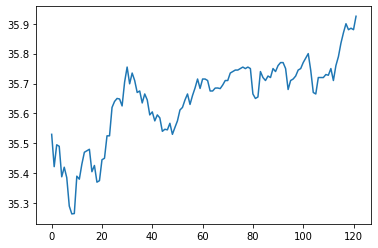

In [33]:
plt.plot(single_data)

In [17]:
def wrap_by_word(s, n):
    '''returns a string where \\n is inserted between every n words'''
    a = s.split()
    ret = ''
    for i in range(0, len(a), n):
        ret += ' '.join(a[i:i+n]) + '\n'

    return ret

In [18]:
def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

In [19]:
from itertools import cycle
cycol = cycle('grcmk')

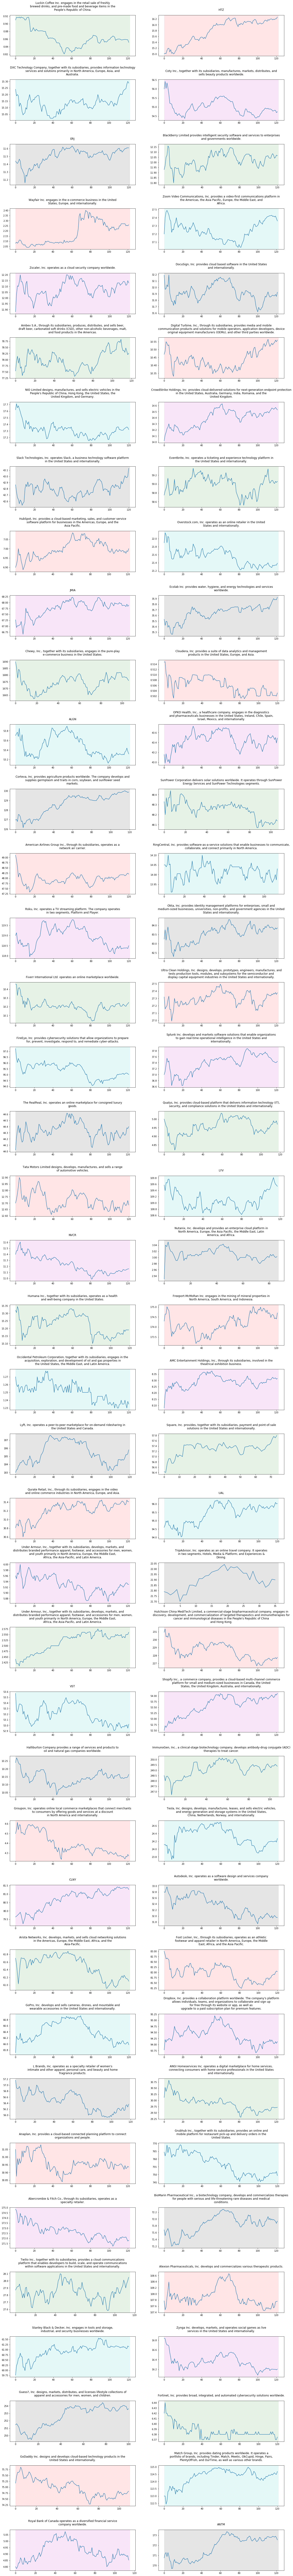

In [34]:
k = 80

fig = plt.figure()
fig.subplots_adjust(top = 0.9)
fig.set_size_inches(18.5, 2*k)
futures = [get_desc.remote(acr) for acr, var in sorted_variances[:k]]
descs = ray.get(futures)

for i, (acr, var) in enumerate(sorted_down_slopes[:k]):
    ax = fig.add_subplot(int(k/2)+1, 2, i+1)
    ax.set_title(wrap_by_word(descs[i], 10),wrap=True)
    
    day_boundaries = np.linspace(0, len(stock_data[acr]), num=days+1)
    for j, (start, finish) in enumerate(zip(day_boundaries[:-1], day_boundaries[1:])):
        ax.axvspan(start, finish, alpha=0.1, color=next(cycol))
    ax.plot(stock_data[acr])
plt.tight_layout()

In [247]:
@ray.remote
def f(x):
    return x * x

futures = [get_desc.remote(acr) for acr, var in sorted_variances[:80]]
print(ray.get(futures))

['HTZ', "Luckin Coffee Inc. engages in the retail sale of freshly brewed drinks, and pre-made food and beverage items in the People's Republic of China.", 'StoneCo Ltd. provides financial technology solutions that empower merchants and integrated partners to conduct electronic commerce across in-store, online, and mobile channels in Brazil.', 'M', "L Brands, Inc. operates as a specialty retailer of women's intimate and other apparel, personal care, and beauty and home fragrance products.", 'Guess?, Inc. designs, markets, distributes, and licenses lifestyle collections of apparel and accessories for men, women, and children.', 'Coty Inc., together with its subsidiaries, manufactures, markets, distributes, and sells beauty products worldwide.', 'The Gap, Inc. operates as an apparel retail company worldwide.', 'Zscaler, Inc. operates as a cloud security company worldwide.', 'Discover Financial Services, through its subsidiaries, operates as a direct banking and payment services company in